In [1]:
import keras
from keras import backend as K
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline
from IPython.display import display

import os, sys

Using TensorFlow backend.


In [2]:
def grab_image(img_path):
    img = image.load_img(img_path, target_size=(100, 100))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    return x

# Load image data
imgdat_glass = np.concatenate([grab_image('./richas_dataset/%d.jpg'%(i)) for i in range(356)])
imgdat_plastic = np.concatenate([grab_image('./richas_dataset/%d.jpg'%(i)) for i in range(356,627)])
imgdat_cardboard = np.concatenate([grab_image('./richas_dataset/%d.jpg'%(i)) for i in range(627,976)])
imgdat_can = np.concatenate([grab_image('./richas_dataset/%d.jpg'%(i)) for i in range(976,1333)])

# Make sure the data loaded correctly
print(imgdat_glass.shape)
print(imgdat_plastic.shape)
print(imgdat_cardboard.shape)
print(imgdat_can.shape)                           

(356, 100, 100, 3)
(271, 100, 100, 3)
(349, 100, 100, 3)
(357, 100, 100, 3)


In [3]:
with open('./richas_dataset/labels.csv', 'r', encoding = 'utf-8-sig') as f:
    labels = f.read().split(',')
Y = keras.utils.to_categorical(labels)

print(Y.shape)

(1333, 4)


In [4]:
# Split labels up by category
imgdat_lens = [imgdat_glass.shape[0], imgdat_plastic.shape[0], imgdat_cardboard.shape[0],
               imgdat_can.shape[0]]
Y_categories = []
index_start = 0
for imgdat_len in imgdat_lens:
    index_end = index_start + imgdat_len
    Y_categories = Y_categories + [Y[index_start : index_end]]
    index_start = index_end

# Shuffle all image data
imgdat_glass = imgdat_glass[np.random.permutation(len(imgdat_glass))]
imgdat_plastic = imgdat_plastic[np.random.permutation(len(imgdat_plastic))]
imgdat_cardboard = imgdat_cardboard[np.random.permutation(len(imgdat_cardboard))]
imgdat_can = imgdat_can[np.random.permutation(len(imgdat_can))]

# Split image categories into training and testing sets
def getHalfLen(img_set):
    return int(len(img_set) / 2)

training_glass = imgdat_glass[ : getHalfLen(imgdat_glass)]
training_glass_labels = Y_categories[0][ : getHalfLen(Y_categories[0])]
training_plastic = imgdat_plastic[ : getHalfLen(imgdat_plastic)]
training_plastic_labels = Y_categories[1][ : getHalfLen(Y_categories[1])]
training_cardboard = imgdat_cardboard[ : getHalfLen(imgdat_cardboard)]
training_cardboard_labels = Y_categories[2][ : getHalfLen(Y_categories[2])]
training_can = imgdat_can[ : getHalfLen(imgdat_can)]
training_can_labels = Y_categories[3][ : getHalfLen(Y_categories[3])]

testing_glass = imgdat_glass[getHalfLen(imgdat_glass) : ]
testing_glass_labels = Y_categories[0][getHalfLen(Y_categories[0]) : ]
testing_plastic = imgdat_plastic[getHalfLen(imgdat_plastic) : ]
testing_plastic_labels = Y_categories[1][getHalfLen(Y_categories[1]) : ]
testing_cardboard = imgdat_cardboard[getHalfLen(imgdat_cardboard) : ]
testing_cardboard_labels = Y_categories[2][getHalfLen(Y_categories[2]) : ]
testing_can = imgdat_can[getHalfLen(imgdat_can) : ]
testing_can_labels = Y_categories[3][getHalfLen(Y_categories[3]) : ]

# Concatenate into training and testing sets
X_train = np.concatenate((training_glass, training_plastic, training_cardboard,
                          training_can))
Y_train = np.concatenate((training_glass_labels, training_plastic_labels, training_cardboard_labels,
                          training_can_labels))

X_test = np.concatenate((testing_glass, testing_plastic, testing_cardboard,
                         testing_can))
Y_test = np.concatenate((testing_glass_labels, testing_plastic_labels, testing_cardboard_labels,
                         testing_can_labels))

# Shuffle training and testing sets
permute = np.random.permutation(len(X_train))
X_train = X_train[permute]
Y_train = Y_train[permute]

permute = np.random.permutation(len(X_test))
X_test = X_test[permute]
Y_test = Y_test[permute]

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)
print('Combined X: ', X_train.shape[0] + X_test.shape[0])

X_train shape:  (665, 100, 100, 3)
Y_train shape:  (665, 4)
X_test shape:  (668, 100, 100, 3)
Y_test shape:  (668, 4)
Combined X:  1333


In [5]:
# Mean-center all image data
for i in range(X_train.shape[0]):
    X_train[i] = (X_train[i] - X_train[i].mean()) / X_train[i].std()

for i in range(X_test.shape[0]):
    X_test[i] = (X_test[i] - X_test[i].mean()) / X_test[i].std()

In [6]:
size = 100

def to_grayscale(img_tensor):
    # Using luminosity formula, which weights green more heavily since human eyes are more senstive to green
    return (0.21 * img_tensor[:, :, :, :1]) + (0.72 * img_tensor[:, :, :, 1:2]) + (0.07 * img_tensor[:, :, :, -1:])

img_in = keras.layers.Input(shape = [size, size, 3])

# Add noise to the input
img = keras.layers.GaussianNoise(0.3)(img_in)
img = keras.layers.MaxPooling2D(2, 2)(img)

# Grayscale convolutions
conv_gsc = keras.layers.Lambda(to_grayscale)(img) # Convert to grayscale w/ luminosity formula
conv_gsc = keras.layers.Conv2D(32, kernel_size = (3, 3))(conv_gsc)
conv_gsc = keras.layers.ELU()(conv_gsc)
conv_gsc = keras.layers.Conv2D(32, kernel_size = (3, 3))(conv_gsc)
conv_gsc = keras.layers.ELU()(conv_gsc)
conv_gsc = keras.layers.MaxPooling2D(2, 2)(conv_gsc)

# Color convolutions
conv_rgb = keras.layers.Conv2D(32, kernel_size = (3, 3))(img)
conv_rgb = keras.layers.ELU()(conv_rgb)
conv_rgb = keras.layers.Conv2D(32, kernel_size = (3, 3))(conv_rgb)
conv_rgb = keras.layers.ELU()(conv_rgb)
conv_rgb = keras.layers.MaxPooling2D(2, 2)(conv_rgb)

# Mix both together and convolve
conv_merged = keras.layers.concatenate([conv_gsc, conv_rgb])
conv_merged = keras.layers.Conv2D(64, kernel_size = (3, 3))(conv_merged)
conv_merged = keras.layers.ELU()(conv_merged)
conv_merged = keras.layers.Conv2D(64, kernel_size = (3, 3))(conv_merged)
conv_merged = keras.layers.ELU()(conv_merged)
conv_merged = keras.layers.MaxPooling2D(2, 2)(conv_merged)

# Convolve with just grayscale
conv_gsc = keras.layers.Conv2D(64, kernel_size = (3, 3))(conv_gsc)
conv_gsc = keras.layers.ELU()(conv_gsc)
conv_gsc = keras.layers.Conv2D(64, kernel_size = (3, 3))(conv_gsc)
conv_gsc = keras.layers.ELU()(conv_gsc)
conv_gsc = keras.layers.MaxPooling2D(2, 2)(conv_gsc)

# Convolve with just color
conv_rgb = keras.layers.Conv2D(64, kernel_size = (3, 3))(conv_rgb)
conv_rgb = keras.layers.ELU()(conv_rgb)
conv_rgb = keras.layers.Conv2D(64, kernel_size = (3, 3))(conv_rgb)
conv_rgb = keras.layers.ELU()(conv_rgb)
conv_rgb = keras.layers.MaxPooling2D(2, 2)(conv_rgb)

# Merge all
conv_merged = keras.layers.concatenate([conv_gsc, conv_rgb, conv_merged])
conv_merged = keras.layers.Conv2D(128, kernel_size = (1, 1))(conv_merged) # Help reduce number of parameters
conv_merged = keras.layers.SpatialDropout2D(0.25)(conv_merged)

# Dense and out
dense = keras.layers.Flatten()(conv_merged)
dense = keras.layers.Dropout(0.25)(dense)
dense = keras.layers.Dense(256, activation = 'relu')(dense)
dense = keras.layers.Dropout(0.5)(dense)
dense = keras.layers.Dense(64, activation = 'relu')(dense)
dense = keras.layers.Dropout(0.5)(dense)
net_out = keras.layers.Dense(Y.shape[1], activation = 'softmax')(dense)

# Color and grayscale convolutions
model = keras.Model(img_in, net_out)
model.compile(loss = keras.losses.categorical_crossentropy,
             optimizer = keras.optimizers.Adam(lr = 0.0001, amsgrad = True),
             metrics = ['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 100, 100, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 50, 50, 3)    0           gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 50, 50, 1)    0           max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_1 (

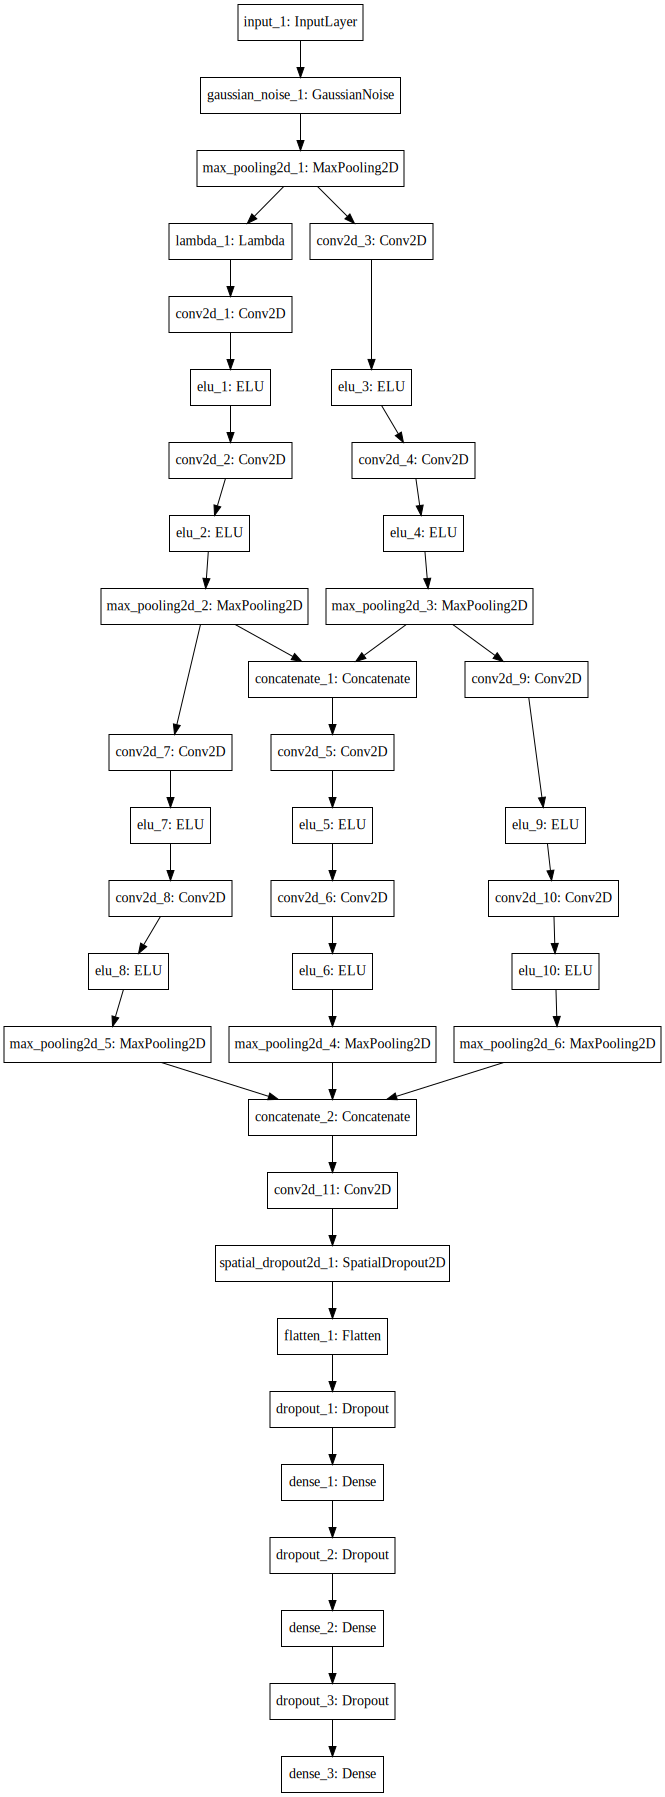

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog = 'dot', format = 'svg'))

In [8]:
from keras_tqdm import TQDMNotebookCallback
history = model.fit(X_train, Y_train, batch_size = 200, 
                    epochs = 100, verbose = 0,
                    validation_data = (X_test, Y_test),
                   callbacks = [TQDMNotebookCallback()])
print('Accuracy: ', model.evaluate(X_test, Y_test)[1] * 100.0, '%')


668/668 [==============================] - 3s 5ms/step
Accuracy:  80.38922144981203 %


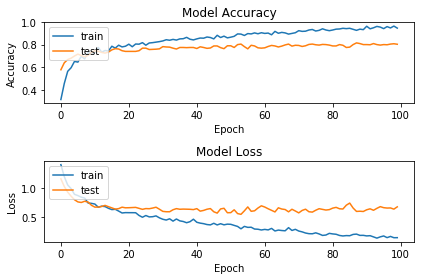

In [9]:
plt.figure(1)

# Accuracy
plt.subplot(211)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

# Loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc = 'upper left')

plt.tight_layout()
plt.show()

In [10]:
preds = model.predict(X_test)

In [11]:
def getIndexOfHighestConfidence(pred):
    highestConfidenceIndex = 0
    for i in range(len(pred)):
        if pred[i] > pred[highestConfidenceIndex]:
            highestConfidenceIndex = i
    return highestConfidenceIndex

def getIndexOfClassification(test):
    classIndex = 0
    for i in range(len(test)):
        if test[i] == 1:
            classIndex = i
            break
    return classIndex

numCorrect = 0
for i in range(len(preds)):
    if getIndexOfHighestConfidence(preds[i]) == getIndexOfClassification(Y_test[i]):
        numCorrect = numCorrect + 1

percentCorrect = numCorrect / len(preds)
print(percentCorrect * 100.0)

80.38922155688623


In [12]:
# Glass, plastic, cardboard, can
# For each category, let's see what the network would generally predict when it saw an image of that type
classCounts = [0, 0, 0, 0] # number of images for each category (from testing data)
predStats = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], 
             [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]] 

for i in range(len(preds)):
    predictedClass = getIndexOfHighestConfidence(preds[i])
    actualClass = getIndexOfClassification(Y_test[i])
    
    classCounts[actualClass] = classCounts[actualClass] + 1
    predStats[actualClass][predictedClass] = predStats[actualClass][predictedClass] + 1

for i in range(4):
    for j in range(4):
        predStats[i][j] = (predStats[i][j] / classCounts[i]) * 100.0

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


In [13]:
classNames = ['Glass', 'Plastic', 'Cardboard', 'Can']

print('Breakdown of network predictions for testing set:\n------------------------')
for i in range(4):
    print(classNames[i] + ':', classCounts[i], 'images')
    print('Network predictions given an image of', classNames[i] + ':')
    for j in range(4):
        print('\t' + classNames[j] + ':', str(np.round(predStats[i][j], 2)) + '%')
    print('\n')

Breakdown of network predictions for testing set:
------------------------
Glass: 178 images
Network predictions given an image of Glass:
	Glass: 78.09%
	Plastic: 2.81%
	Cardboard: 8.43%
	Can: 10.67%


Plastic: 136 images
Network predictions given an image of Plastic:
	Glass: 26.47%
	Plastic: 48.53%
	Cardboard: 2.21%
	Can: 22.79%


Cardboard: 175 images
Network predictions given an image of Cardboard:
	Glass: 1.14%
	Plastic: 0.0%
	Cardboard: 98.86%
	Can: 0.0%


Can: 179 images
Network predictions given an image of Can:
	Glass: 6.7%
	Plastic: 1.12%
	Cardboard: 3.35%
	Can: 88.83%




In [28]:
model.save('model_alt.model')
model.save_weights('model_alt.weights')